In [42]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

In [43]:
df = pd.read_csv('Cleaned_Data_For_MachineLearing.csv')

In [44]:
df.head()

,Unnamed: 0,Brand,Year,Title,UsedOrNew,Transmission,FuelType,Kilometres,CylindersinEngine,BodyType,Price,Colour
0,0,Ssangyong,2022,Ssangyong Rexton Ultimate,DEMO,Automatic,Diesel,5595,4,SUV,51990,White
1,1,MG,2022,MG MG3 Auto,USED,Automatic,Premium,16,4,Hatchback,19990,Black
2,3,Mercedes-Benz,2011,Mercedes-Benz E500 Elegance,USED,Automatic,Premium,136517,8,Coupe,32990,White
3,4,Renault,2022,Renault Arkana Intens,USED,Automatic,Unleaded,1035,4,SUV,34990,Grey
4,5,Toyota,2004,Toyota Estima T,USED,Automatic,Unleaded,160230,4,Commercial,9990,Grey


In [45]:
# Drop Unnamed column
df.drop('Unnamed: 0', axis=1, inplace=True, errors='ignore')

In [46]:
# Define categorical and numerical columns
categorical_columns = ['Brand', 'Title', 'UsedOrNew', 'Transmission', 'FuelType', 'BodyType', 'Colour']
numerical_columns = ['Year', 'Kilometres', 'CylindersinEngine']

In [47]:
# Create a column transformer for preprocessing
preprocessor = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), categorical_columns),
    (StandardScaler(), numerical_columns),
    remainder='passthrough'
)

In [48]:
# Split the data into features (X) and target variable (y)
X = df.drop('Price', axis=1)
y = df['Price']
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1000)

In [49]:
# Try RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=1000)

# Create a pipeline with RandomForestRegressor
rf_pipe = make_pipeline(preprocessor, rf)


In [50]:
# Fit the model
rf_pipe.fit(X_train, y_train)
# Evaluate the model
y_pred_train = rf_pipe.predict(X_train)
r2_train = r2_score(y_train, y_pred_train)
y_pred_test = rf_pipe.predict(X_test)
r2_test = r2_score(y_test, y_pred_test)

In [51]:
# Calculate RMSE on the training set
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
# Calculate RMSE on the testing set
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

In [52]:
print("RMSE on Training Set:", rmse_train)
print("R-squared:", r2_train)
print("RMSE on Testing Set:", rmse_test)
print("R-squared:", r2_test)

RMSE on Training Set: 2469.513446148027
R-squared: 0.9819274970968309
RMSE on Testing Set: 6554.489356133076
R-squared: 0.8725067374737051


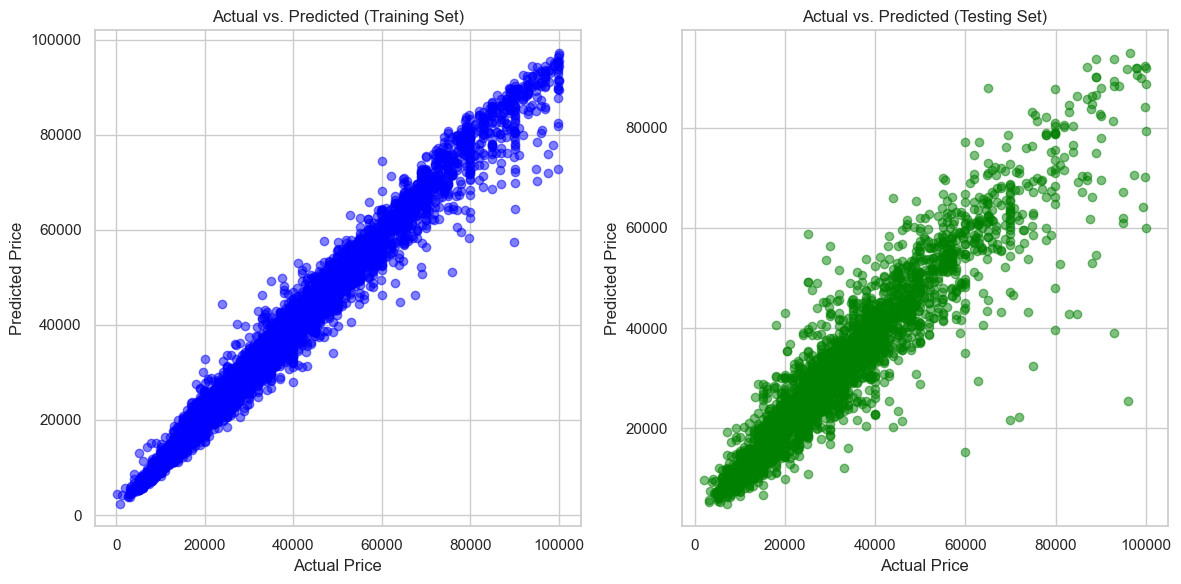

In [53]:
# Plotting the results for the training set
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_train, y_pred_train, color='blue', alpha=0.5)
plt.title('Actual vs. Predicted (Training Set)')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.grid(True)

# Plotting the results for the testing set
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_test, color='green', alpha=0.5)
plt.title('Actual vs. Predicted (Testing Set)')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.grid(True)

plt.tight_layout()
plt.show()

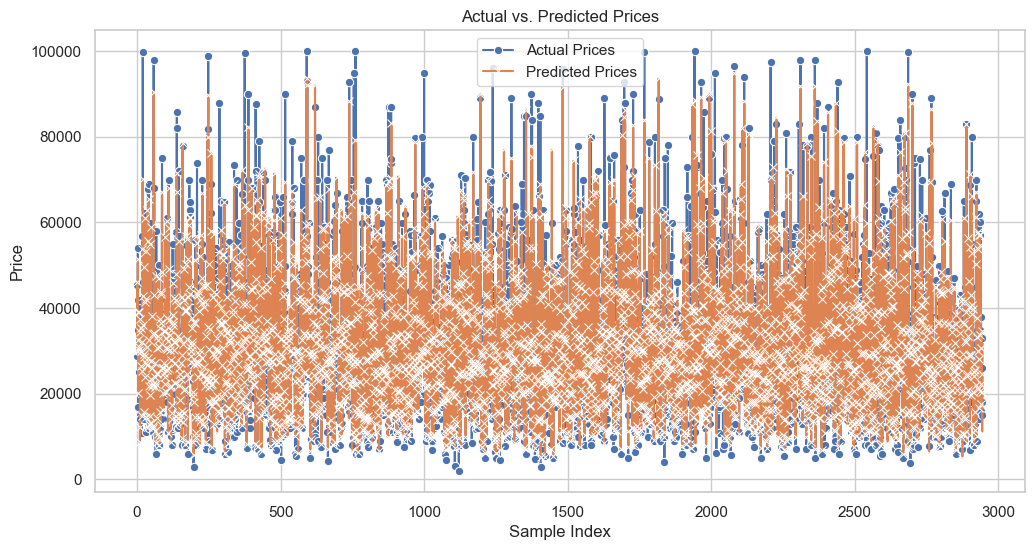

In [54]:
# Create an array of indices for the test set samples
indices = np.arange(len(y_test))

# Create a DataFrame for easier plotting with Seaborn
plot_data = pd.DataFrame({'Index': indices, 'Actual Prices': y_test, 'Predicted Prices': y_pred_test})

# Set the style
sns.set(style="whitegrid")

# Create a line plot
plt.figure(figsize=(12, 6))
sns.lineplot(x='Index', y='Actual Prices', data=plot_data, label='Actual Prices', marker='o')
sns.lineplot(x='Index', y='Predicted Prices', data=plot_data, label='Predicted Prices', marker='x')

plt.xlabel('Sample Index')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Prices')
plt.legend()
plt.show()

In [55]:
# Add a new columnh into df
df['Predicted Price'] = rf_pipe.predict(X)
# Calculate the residual
df['Residual'] = df['Price'] - df['Predicted Price']
# Calculate the percentage difference
df['Difference%'] = (df['Residual'] / df['Price']) * 100
# Display the DataFrame with actual, predicted prices, residuals, and percentage differences
result_columns = ['Price', 'Predicted Price', 'Residual', 'Difference%']
df[result_columns]

,Price,Predicted Price,Residual,Difference%
0,51990,56114.290000,-4124.290000,-7.932852
1,19990,20067.326905,-77.326905,-0.386828
2,32990,41314.950000,-8324.950000,-25.234768
3,34990,43352.970000,-8362.970000,-23.901029
4,9990,12818.900000,-2828.900000,-28.317317
...,...,...,...,...
14724,36770,36146.750000,623.250000,1.694996
14725,29500,29716.120000,-216.120000,-0.732610
14726,35280,35853.880000,-573.880000,-1.626644
14727,41888,42851.220000,-963.220000,-2.299513


In [56]:
# Save the model
with gzip.open('RandomForestRegressor.pkl', 'wb') as model_file:
    saved_model = pickle.dump(rf_pipe, model_file)

In [57]:
# Open the saved model
with gzip.open('RandomForestRegressor.pkl', 'rb') as model_file:
    saved_model = pickle.load(model_file)

In [58]:
# Make a prediction with our model
new_data = pd.DataFrame(columns=['Brand', 'Year', 'Title', 'UsedOrNew', 'Transmission', 'FuelType', 'Kilometres', 'CylindersinEngine', 'BodyType', 'Colour'],
                        data=np.array(['Ssangyong',2022,'Ssangyong Rexton Ultimate','DEMO','Automatic','Diesel',5595,4,'SUV','White']).reshape(1, 10))
new_data.drop('Unnamed: 0', axis=1, inplace=True, errors='ignore')


In [59]:
prediction = saved_model.predict(new_data)
print(f'Predicted Price: {prediction[0]}')

Predicted Price: 56114.29
